# Von Mises material with nonlinear isotropic and kinematic hardening

Author(s): Olli Väinölä <olli.vainola@student.oulu.fi>

In this notebook is an small tutorial, how to create a Von Mises material with hardening. Equations are formulated into rate depended form. Code may or may not include some bugs..

# Theory section

### Continuum equations

Stress:

$\sigma = C : \epsilon^e$

$C$ is material tensor and $\epsilon$ total strain.
Total strain is divided into elastic and plastic part:

$\epsilon = \epsilon^e + \epsilon^p$

now let's define a strain rate, which is strain increment divide with time increment $dt$

$\frac{d\epsilon}{dt} = \dot \epsilon =  \dot \epsilon^e + \dot \epsilon^p$

Now same procedure for stress and substitute $\dot \epsilon^e$

$\dot \sigma = C : \dot \epsilon^e =  C : (\dot \epsilon - \dot \epsilon^p )$

Only thing to do is to define yield function. Now we're using Von Mises material:

$f(\sigma - X, R(\alpha)) = \sqrt{3J_2(\sigma-X))} - R(\alpha)$ = 0

$f(\sigma, \sigma_y) = \sqrt{3J_2(\sigma))} - \sigma_y$ = 0

$J_2 = \frac{1}{6}((\sigma_{11}-\sigma_{22})^2+(\sigma_{22}-\sigma_{33})^2+(\sigma_{33}-\sigma_{11}))^2 + (\sigma_{12}^2 + \sigma_{23}^2 + \sigma_{31}^2)$ 


In [1]:
# imports
using PyPlot
using ForwardDiff
using NLsolve

Let's create a isotropic Hooke material.

In [2]:


"""
Create a isotropic Hooke material matrix C 

More information: # http://www.efunda.com/formulae/solid_mechanics/mat_mechanics/hooke_isotropic.cfm

Parameters
----------
    E: Float
        Elastic modulus
    ν: Float
        Poisson constant

Returns
-------
    Array{Float64, (6,6)}
"""
function hookeStiffnessTensor(E, ν)
    a = 1 - ν
    b = 1 - 2*ν
    c = 1 + ν
    multiplier = E / (b * c)
    return Float64[a ν ν 0 0 0;
                   ν a ν 0 0 0;
                   ν ν a 0 0 0;
                   0 0 0 b 0 0;
                   0 0 0 0 b 0;
                   0 0 0 0 0 b].*multiplier
end

# Pick material values
E = 200.0e3
ν =  0.3
C = hookeStiffnessTensor(E, ν)

6x6 Array{Float64,2}:
 2.69231e5  1.15385e5  1.15385e5  0.0        0.0        0.0      
 1.15385e5  2.69231e5  1.15385e5  0.0        0.0        0.0      
 1.15385e5  1.15385e5  2.69231e5  0.0        0.0        0.0      
 0.0        0.0        0.0        1.53846e5  0.0        0.0      
 0.0        0.0        0.0        0.0        1.53846e5  0.0      
 0.0        0.0        0.0        0.0        0.0        1.53846e5

# Defining equations for the calculation

Functions are defined for strain controller simulation

In [3]:

"""
Equivalent tensile stress. 

More info can be found from: https://en.wikipedia.org/wiki/Von_Mises_yield_criterion
    Section: Reduced von Mises equation for different stress conditions

Parameters
----------
    σ: Array{Float64, 6}
        Stress in Voigt notation

Returns
-------
    Float
"""
function σₑ(σ)
    e1 = (σ[1] - σ[2])^2
    e2 = (σ[2] - σ[3])^2
    e3 = (σ[3] - σ[1])^2
    e4 = σ[4]^2 
    e5 = σ[5]^2
    e6 = σ[6]^2
    return sqrt((e1 + e2 + e3 + 6 * (e4 + e5 + e6)) / 2.)
end


"""
Von Mises Yield criterion

More info can be found from: http://csm.mech.utah.edu/content/wp-content/uploads/2011/10/9tutorialOnJ2Plasticity.pdf

Parameters
----------
    σ: Array{Float64, 6}
        Stress in Voigt notation
    k: Float64
        Material constant, Yield limit

Returns
-------
    Float
"""
function vonMisesYield(σ, R)
    σₑ(σ) - R
end


"""
Function for NLsolve. Inside this function are the functions where we want to find root.
Ψ is the yield function below. Functions defined here:

    dσ - C (dϵ - dλ*dΨ/dσ) = 0
                 σₑ(σ) - k = 0

Parameters
----------
    params: Array{Float64, 7}
        Array containing values from solver
    dϵ: Array{Float64, 6}
        Strain rate vector in Voigt notation
    C: Array{Float64, (6, 6)}
        Material tensor
    k: Float
        Material constant, yield limit
    Δt: Float
        time increment
    σ_begin:Array{Float64, 6}
        Stress vector in Voigt notation
    p: Float
        Accumulated plastic strain
    X: Array{Float64, 6}
        Kinematic hardening tensor
    R: Function
        Calculates isotropic hardening as a function of accumulated plastic strain
    α:Float
        Accumulated kinematic evolution variable
    dα: Function
        Calculates kinematic evolution variables rate as a function of accumulated plastic slip rate
    fX: Function
        Calculates the kinematic 

Returns
-------
    Array{Float64, 7}, return values for solver
"""
function G(params, dϵ, C, Δt, σ_begin, p, X, R, α, dα, fX)
    
    # Initializing parameters
    σ = params[1:6]
    dλ = params[end]

    # Stress rate
    dσ = (σ_begin - σ) / Δt
    
    # This required some hacking with ForwardDiff..
    X_kine = [X[:]; 0.0]
    σ_shifted = params - X_kine
    
    # Creating wrapper for gradient
    yield(pars) = vonMisesYield(pars, R(p))
    dfdσ = ForwardDiff.gradient(yield)
    vars = dfdσ(σ_shifted)
    dΨdσ = vars[1:6]
    
    # Calculating plastic strain rate
    dϵp = dλ * dΨdσ
    
    # Calculating material evolution variables
    dp = sqrt(2./3. * double_contraction(dϵp))
    p_cum = p + dp
    dα_ = dα(dp, dΨdσ, X)
    α_sum = α + dα_
    
    # updating material parameters
    R_ = R(p_cum)
    X_ = fX(α_sum)
    
    # Calculating new stress
    σ_kinematic = σ - X_

    # Evaluating equations
    function_1 = dσ - C * (dϵ - dϵp)
    function_2 = vonMisesYield(σ_kinematic, R_)
    [function_1[:]; function_2]
end

"""
This is a fast implementation for double contraction, a=b:c, tensor operation

Parameters
----------
    a: Array{Float64, 6}

Returns
-------
    Float
"""
function double_contraction(a; b=a)
    indexes = [1, 2, 3, 4, 5, 6, 4, 5, 6]
    summation = 0
    for i in indexes
        summation += a[i]*b[i]
    end
    summation
end

"""
Function which calculates the stress. Also handles if any yielding happens

Parameters
----------
    dϵ: Array{Float64, 6}
        Strain rate vector in Voigt notation
    Δt: Float
        time increment
    σ: Array{Float64, 6}
        Last stress vector in Voigt notation
    C: Array{Float64, (6, 6)}
        Material tensor
    p: Float
        Accumulated plastic strain
    X: Array{Float64, 6}
        Kinematic hardening tensor
    R: Function
        Calculates isotropic hardening as a function of accumulated plastic strain
    α:Float
        Accumulated kinematic evolution variable
    dα: Function
        Calculates kinematic evolution variables rate as a function of accumulated plastic slip rate
    fX: Function
        Calculates the kinematic 

Returns
-------
    Tuple
        returns following parameters: p, X, α, σ. See Parameters for definitions
"""
function calculate_stress(dϵ, Δt, σ, C, p, X, R, α, dα, fX)

    # Test stress
    σ_tria = σ + C * dϵ * Δt
    
    # Calculating yield
    yield = vonMisesYield(σ_tria - X, R(p))
    if yield > 1
        σ_start = copy(σ)
        # Yielding happened
        # Creating functions for newton: xₙ₊₁ = xₙ - df⁻¹ * f and initial values
        initial_guess = [σ[:]; 1.0]
        f(σ_)  = G(σ_, dϵ, C, Δt, σ_tria, p, X, R, α, dα, fX)
        df     = ForwardDiff.jacobian(f)
        
        # Calculating root 
        result = nlsolve(not_in_place(f, df), initial_guess).zero
        
        # Extracting values
        σ      = result[1:6]        
        dλ     = result[end]

        # Wrapper for gradient
        yield_f(σ_) = vonMisesYield(σ_, R(p))
        dfdσ_ = ForwardDiff.gradient(yield_f)
        nall = dfdσ_(σ)
        dΨdσ = nall[1:6]
        
        # Stress rate and plastic strain rate
        dσ = (σ_start - σ) / Δt
        dϵᵖ = dϵ - C \ dσ
        
        # Updating material parameters
        dp = sqrt(2/3 * double_contraction(dϵᵖ))
        p += dp
        dα_ = dα(dp, dΨdσ, X)
        α += dα_
        X = fX(α)
    else
        σ = σ_tria
    end
    return (p, X, α, σ)
end

calculate_stress (generic function with 1 method)

# Defining strain history

In the ideal plastic example, we only had tension stress. In this example we'll take it a bit further and calculate the cyclic strain

In [4]:
steps = 600

ϵ_tot = zeros(Float64, (steps, 6))

max_strain = 0.004
ϵ_tot[:, 1] = max_strain * sin(linspace(0, 5*pi/2, steps))
ϵ_tot[:, 2] = max_strain * sin(linspace(0, 5*pi/2, steps)).*-ν
ϵ_tot[:, 3] = max_strain * sin(linspace(0, 5*pi/2, steps)).*-ν
println("Done")

Done


# Hardening evolution equations

Followig equations are in charge of evolution of isotropic and kinematic parameters

In [5]:
function nonlinearIsotropicHardening(ϵp_cum, R0, Q, b)
    return R0 + Q * (1 - exp(-b * ϵp_cum))
end

function dα_function(dϵp_cum, n, X, D, C)
    return dϵp_cum * (n - (3*D)/(2*C) * X)
end

function nonlinearKinematicHardening(α,C)
    return 2/3 * C * α
end

nonlinearKinematicHardening (generic function with 1 method)

# Simulation

Ok, we're good to go! Now we just need to define yield limit and the main loop.

This simulation is not time dependent, but since it's already defined in the equations we'll give it value 1

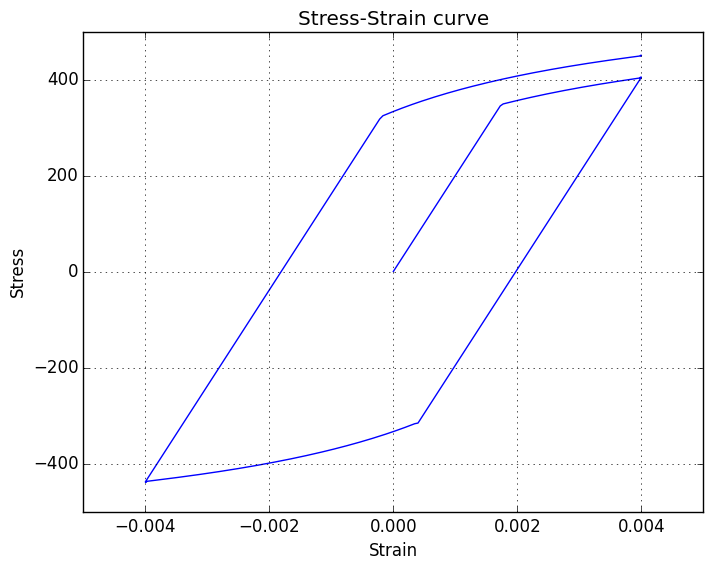

In [6]:
ϵ_last = zeros(Float64, (6)) # Last total strain
ϵᵖ = zeros(Float64, (6))  # Plastic strain
σ = zeros(Float64, (6, 1)) # Stress
Δt = 1.0 # time increment
σy =  350.0 # Yield stress
ss = zeros(Float64, steps) # plotting stress
ee = zeros(Float64, steps) # plotting strain
pp = zeros(Float64, steps) # plotting strain

# Isotropic hardening
b = 0.3    # Saturation rate: b
Q = 15000.0 # Saturation hardening: Q

# Kinematic hardening
D = 250.0 # Saturation rate D
Ck = 40000.0 # saturation hardening C/D
X = zeros(Float64, (6)) # kinematic hardening tensor

p = 0.0 # Accumulated plastic strain
α = zeros(Float64, (6)) # Kinematic evolution parameter

# Isotropic hardening
R(ϵp_cum) = nonlinearIsotropicHardening(ϵp_cum, σy, Q, b)

# kinematic hardening
dα(dϵp_cum, n, X) = dα_function(dϵp_cum, n, X, D, Ck)
fX(α) = nonlinearKinematicHardening(α,Ck)

for i=1:steps
    
    # Plotting
    ss[i] = σ[1]
    ee[i] = ϵ_last[1]
    pp[i] = R(p)
    
    # Actual calculation
    dϵ = (reshape(ϵ_tot[i, :, :], (6, 1)) - ϵ_last) / Δt 
    p, X, α, σ = calculate_stress(dϵ, Δt, σ, C, p, X, R, α, dα, fX)
    ϵ_last += dϵ * Δt
end
PyPlot.plot(ee, ss)
PyPlot.title("Stress-Strain curve")
PyPlot.xlabel("Strain")
PyPlot.ylabel("Stress")
PyPlot.ylim([-500, 500])
PyPlot.xlim([-0.005, 0.005])
PyPlot.grid()